### 1. Requirements to run and typical run time
#### Data source: recorded by ourselves.
  Link to our data set: https://github.com/thyphdo/BigDataProject/tree/master/Final%20Submission/Final%20Data
    
  In order for the notebook to work, please put the notebook in the same folder with all the data files
#### Information for non-typical libraries
  Librosa: https://librosa.github.io/librosa/
#### References:
   Visualizing Sound files:https://musicinformationretrieval.com/energy.html
   
   PCA:https://musicinformationretrieval.com/pca.html
#### Runtime:
   Runtime for machine learning: Approx. 30 min

   Runtime for detecting and remove filler: Approx. 5 sec
### 2. Brief description and goals of the project

First we had several approaches like mimic celebrity voices (vocal mimicry), detect and remove stuttering in speech and we decided we would do detect and remove fillers from speech recordings, which will be a very reasonable stepping stone for those bigger goals.

Our final goal is detecting if a sound is a filler word. Then we verify if a sentence contains filler words, and  remove the filler word that the machine detects and we finally produce a sentence that is without the filler words.
### 3. Group members
    Juan Eckert

    Thy Do

    Tony Shi
### 4. Summary of Findings
We find that for our kind of data (audio file to be determined as filler and non-filler), using the clustering algorithm, basic neural network and logistic regression are not suitable options. And we can see that based on our classification algorithm, the kernel SVM works the best. There are a lot of rooms for modifying and for possible erros due to many assumptions we made from the data collection phase (high skew for male voice and american accent, clean background) to the PCA phase (the chosen featured data's dimension is 20x4).

Also, we found out that the talking speech may not be important as long as the speaker has a slightly clearer pause when it comes to the filler words. Besides, in order to improve the final smoothed version of audio, we should record the timestamp of each chunk when splitting, and then remove only that portion of filler chunk out, instead of glueing all the chunks together. 

Additionally, we find out that another possible approach for this project maybe looking at the transcripts or try using the pre-constructed voice to text algorithms and detect filler words by combining both transcripts and audio files

# 1. Import libraries

In [121]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import os
import pandas as pd
import sklearn
import re, ast
import matplotlib.pyplot as plt

#algo imports
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.pipeline import make_pipeline
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC # "Support vector classifier"

# 2. Explore data (forrestgump_filler)

In [16]:
#Load the .wav file into wave with frequency of fs
filename = 'forrestgump_filler'
wave, fs = librosa.load(filename+'.wav')

Frequency: 22050
Duration: 8.95201814058957 s
Number of points: 197392


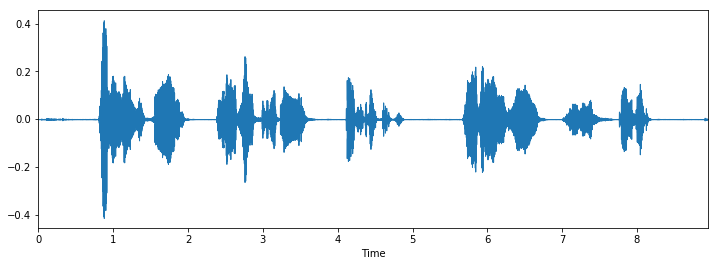

In [23]:
print("Frequency:",fs)
print("Duration:",len(wave)/fs,"s")
print("Number of points:",len(wave))
#Visualize the audio file in time domain
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)
plt.show()

In [22]:
ipd.Audio(wave, rate=fs)

### 2.1 Trim the leading silence portion

#### Source: https://musicinformationretrieval.com/energy.html

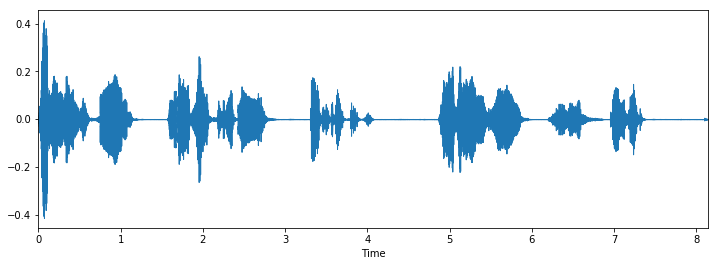

In [25]:
def strip(x, frame_length, hop_length):

    # Compute RMSE.
    rmse = librosa.feature.rmse(x, frame_length=frame_length, hop_length=hop_length, center=True)
    
    # Identify the first frame index where RMSE exceeds a threshold.
    thresh = 0.01
    frame_index = 0
    while rmse[0][frame_index] < thresh:
        frame_index += 1
        
    # Convert units of frames to samples.
    start_sample_index = librosa.frames_to_samples(frame_index, hop_length=hop_length)
    
    # Return the trimmed signal.
    return x[start_sample_index:]
wave = strip(wave, 20, 10) #Trim with 20ms frame length and 10ms hop length
plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)
plt.show()

# 3. Splitting data into chunks

### End-point detection (VAD) 

#### Detecting the start point and end point of voice activity

#### Source: https://www.kaggle.com/jerrypeng/dsp-tutorial-3-demos-for-speech-processing

### 3.1 Calculate RMS and Zero Crossing Rate


In [27]:
frame_len = int(40 * fs /1000) # 20ms
frame_shift = int(10 * fs /1000) # 10ms
# calculate RMS
rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
rms = rms[0]
rms = librosa.util.normalize(rms, axis=0)

# calculate zero-crossing rate
zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
zrc = zrc[0]

### 3.2 Visualize the amplitude with RMS (Root Mean Square) Energy that measures amplitude and Zero Crossing Rate that measures mean frequency

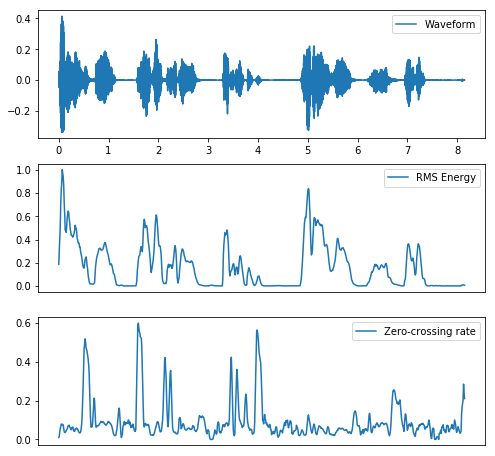

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(3, 1, 1)
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
plt.legend(loc='best')

plt.subplot(3, 1, 2)
plt.plot(rms.T, label='RMS Energy')
plt.xticks([])
plt.legend(loc='best')

plt.subplot(3, 1, 3)
plt.plot(zrc.T, label='Zero-crossing rate')
plt.xticks([])
plt.legend(loc='best')
plt.show()

### 3.3 Set threshold of speech and silence

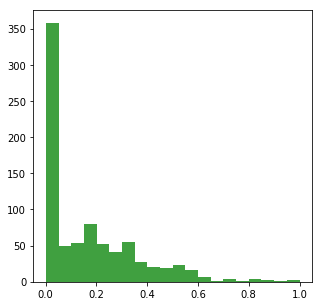

In [31]:
plt.figure(figsize=(5, 5))
n, bins, patches = plt.hist(rms.T, 20, facecolor='g', alpha=0.75)

Based on the histogram above, we can set threshold of RMS at 0.1 and 0.5 for zrc.

In [32]:
#Getting all the cut point indices
frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]

### 3.4 Based on the frame indices, get start and end points of frames

In [161]:
def getboundaries(frame_idxs, frame_shift, fs):
    #get the first frame index
    start_idxs = [frame_idxs[0]]
    end_idxs = []

    #get the length of list of frame indices
    shapeofidxs = np.shape(frame_idxs)

    #for each index in the list 
    for i in range(shapeofidxs[0]-1):
        #if the next index is in a different frame (difference > 1)
        if (frame_idxs[i + 1] - frame_idxs[i]) != 1:
            #i is an end index 
            end_idxs.append(frame_idxs[i])
            #i+1 is a start index
            start_idxs.append(frame_idxs[i+1])
            
    #last index of the list will be an end index
    end_idxs.append(frame_idxs[-1])
    
    # del the last boundaries if it is both start point and end point.
    if end_idxs[-1] == start_idxs[-1]:
        end_idxs.pop()
        start_idxs.pop()
    assert len(start_idxs) == len(end_idxs), 'Error! Num of start_idxs doesnt match Num of end_idxs.'
    
    #convert into np.array
    start_idxs = np.array(start_idxs)
    end_idxs = np.array(end_idxs)
    
    #from index, convert to time 
    start_t = start_idxs * frame_shift / fs
    end_t = end_idxs * frame_shift / fs
    return start_t, end_t

In [162]:
start_t, end_t = getboundaries(frame_idxs,frame_shift,fs)
print("Number of chunks: ", len(start_t))

Number of chunks:  14


### 3.5 Visualize the wave with frames (Red: start, Green: end)

Problem: The start and end time periods yielded out from getBoundaries do not match with the time domain so that we can iterate through wave file and save all the points of a frame 

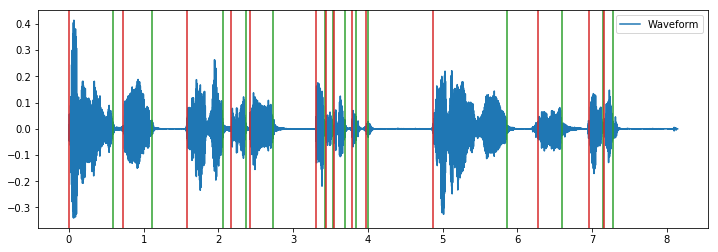

In [35]:
plt.figure(figsize=(12, 4))
t = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(t, wave, label='Waveform')
for s, e in zip(start_t, end_t):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 3.6 Reformate the time frame limits computed by the algorithms (to be consistence with the wave's time domain)

In [36]:
#Reformat the time frame limits computed by the algorithms 

#Cut down to 10 decimal place, used to be 16
start_t = [(float("{0:.10f}".format(x))) for x in start_t]
end_t = [(float("{0:.10f}".format(i))) for i in end_t]

#Compare with the real timeline of the file, take the time period nearest to 4 decimal place 
s = 0
e = 0
#Retrieve the time frame correspond to the real time graph
new_start = []
new_end = []
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for t in time: 
    if s < len(start_t) and abs(start_t[s]-t) < 0.0001:
#         print("start","algo: ", start_t[s],"    " ,"original from graph: ", t)
        new_start.append(t)
        s = s + 1
    elif e < len(end_t) and abs(end_t[e]-t) < 0.0001:
#         print(" end","algo: ", end_t[e], "    ","original from graph: ", t)
        new_end.append(t)
        e = e + 1

### 3.7 Redraw the graph

Just to make sure there's no huge discrepency


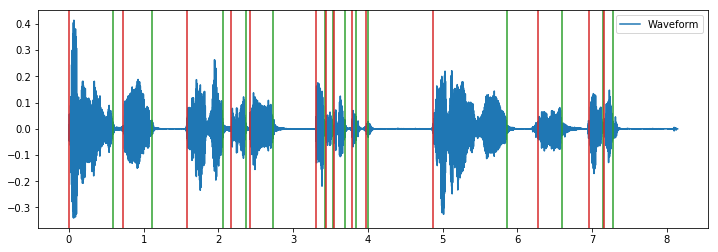

In [37]:
#Redraw the graph
plt.figure(figsize=(12, 4))
time = np.linspace(0, len(wave)/fs, len(wave))
plt.plot(time, wave, label='Waveform')
for s, e in zip(new_start, new_end):
    plt.axvline(x=s, color='#d62728') # red vertical line
    plt.axvline(x=e, color='#2ca02c') # green vertical line
plt.legend(loc='best')
plt.show()

### 3.8 Cut the original wave file into chunks corresponding the computed frame 

In [41]:
#Cut the original wave file into chunks corresponding the computed frame 
chunks = []
frame = []
inFrame = False
frame_idx = 0
num_frames = len(new_start)
time = np.linspace(0, len(wave)/fs, len(wave))
time = [(float("{0:.10f}".format(a))) for a in time]
for w,t in zip(wave,time):
    #if t is the beginning of a frame
    if t == new_start[frame_idx]:
#         print("Start Frame!",t)
        #raise the inFrame flag, start collecting the wave
        inFrame = True
    #if t is the end of a frame
    elif t == new_end[frame_idx]:
#         print("End Frame!",t)
        #collect the last value
        frame.append(w)
        #add the frame to the chunks
        chunks.append(frame)
        #reset the frame 
        frame = []
        #increment the frame index 
        frame_idx += 1
        #unflag the inFrame flag, stop collecting the wave
        inFrame = False
    #if t is somewhere in the frame, collect it
    if inFrame == True: 
        frame.append(w)
    #if no frame left to search for, break
    if frame_idx == num_frames:
        break
print("There are",len(chunks),"chunks. Each has length of",[round(len(c)/fs,2) for c in chunks],"seconds")

There are 14 chunks. Each has length of [0.59, 0.38, 0.49, 0.19, 0.31, 0.12, 0.09, 0.14, 0.05, 0.03, 0.98, 0.32, 0.18, 0.12] seconds


### 3.8.1 If chunks has less than 1500 points, consider inaudible sound -> delete

In [43]:
chunks = [chunk for chunk in chunks if len(chunk) > 1500]
print("New number of chunks:",len(chunks))

New number of chunks: 12


### 3.9 Check some of the first chunks 

In [44]:
print("Num points:",len(chunks[0]))
ipd.Audio(chunks[0], rate=fs)

Num points: 12979


In [45]:
#Uhh
print("Num points:",len(chunks[1]))
ipd.Audio(chunks[1], rate=fs)

Num points: 8361


In [46]:
#Said life
print("Num points:",len(chunks[2]))
ipd.Audio(chunks[2], rate=fs)

Num points: 10781


# 4. Extract chunks into many chunk.wav files

In [73]:
for i, chunk in enumerate(chunks):
    out_file = filename+"chunk{0}.wav".format(i)
    librosa.output.write_wav(out_file, np.array(chunk), fs)

# 5. Perform PCA and data scaling

### 5.1 Plot the CVE of each chunk to determine a good number of components 

#### 4 is chosen after some observation of CVE plot of different audio files

In [67]:
def plot_CVE(chunks):
    for c in chunks:
        X = librosa.feature.mfcc(np.array(c), sr=fs)
        X = sklearn.preprocessing.scale(X)  
        pca = PCA().fit(X)
        plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.show()

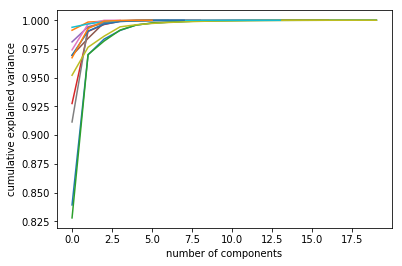

In [68]:
plot_CVE(chunks)

### 5.2 Compute some features using MFCC and scale the features to have zero mean and unit variance:

#### Suggested by: https://musicinformationretrieval.com/pca.html


In [69]:
#Return a uniformed matrix of data points with 4 columns 
def gen_PCA(wave,num_components,fs):
    #Compute some features
    X = librosa.feature.mfcc(wave, sr=fs)
    #Scale the feature to have zero mean
    X = sklearn.preprocessing.scale(X)    
    print ("Old Shape",X.shape)
    #print("Mean",X.mean())
    model = sklearn.decomposition.PCA(n_components=num_components, svd_solver='auto')
    Y = model.fit_transform(X)
    print ("New Shape",Y.shape)
    print ("Component shape",model.components_.shape)
    return Y

In [71]:
new_matrix = gen_PCA(wave, 4, fs)

Old Shape (20, 351)
New Shape (20, 4)
Component shape (4, 351)


# 6. Divide audio file into chunks, perform PCA, convert and save as .csv file 

#### The proces_audio function below is the combination of many pre-processing functions above. The function will take in an audio filename,  output a dataframe containing the featured wave and a isFiller column of value 0 (non-filler by default)

#### This function is used to: 
    1. process audio files in the data for training the model
    2. process input audio file for testing the model (the demo)

In [76]:
#SPLIT AUDIO FILE INTO NUMBERED .WAV CHUNK FILES
COMPONENT_NUMBER = 4

def splitIntoChunk(path, chunks, fs):    
    filenames = path.split("/")
    orgFilename = filenames[0] #filler
    
    for i, chunk in enumerate(chunks):
        out_file = "chunk{0}.wav".format(i)
        librosa.output.write_wav(out_file,np.array(chunk),fs)
    filler = 0
    return dfFormat(orgFilename, filler, fs)
        
# Extracts audio chunks from the splitAudio folder and passes them into the chunkInfo method    
def dfFormat(orgFilename, filler, fs):
    result = []
    for chunk in os.listdir("."):
        if "_" not in chunk and "chunk" in chunk:
            wav, fs = librosa.load(chunk)
            data = chunkInfo(chunk[5:7], orgFilename, filler, wav, fs)
            result.append(data)
    return result        

# return an array as such: [orgin filename, chunk number, PCA matrix, isFiller] to create a df  
def chunkInfo(chunkNum, orgFilename, filler,wav, fs):
    chunkNumber = int(chunkNum.replace(".",""))
    waveMatrix = gen_PCA(wav, COMPONENT_NUMBER, fs)
    isFiller = 0
    result = [orgFilename, chunkNumber, waveMatrix, isFiller] # 0 for now

    return result

In [87]:
def process_audio(filename): 
    print("---Loading the " + filename + ".wav audio file---")
    wave, fs = librosa.load(filename + '.wav')
    wave = strip(wave, 20, 10)
    
    #CALCULATE RMS AND ZERO CROSSING
    print("---Calculating RMS and Zero Crossing Rate---")
    frame_len = int(40 * fs /1000) # 20ms
    frame_shift = int(10 * fs /1000) # 10ms
    # calculate RMS
    rms = librosa.feature.rmse(wave, frame_length=frame_len, hop_length=frame_shift)
    rms = rms[0]
    rms = librosa.util.normalize(rms, axis=0)

    # calculate zero-crossing rate
    zrc = librosa.feature.zero_crossing_rate(wave, frame_length=frame_len, hop_length=frame_shift, threshold=0)
    zrc = zrc[0]
    #zrc = librosa.util.normalize(zrc, axis=0)
    
    frame_idxs = np.where( (rms > 0.1) | (zrc > 0.5) )[0]
    
    #LIST OF START INDICES AND STOP INDICES OF CHUNKS
    print("---Identifying start and end time of chunks---")
    start_t, end_t = getboundaries(frame_idxs, frame_shift, fs)
    
    #REFORMAT THE COMPUTED TIME FRAME LIMITS
    #Cut down to 10 decimal place, used to be 16
    start_t = [(float("{0:.10f}".format(x))) for x in start_t]
    end_t = [(float("{0:.10f}".format(i))) for i in end_t]

    #Compare with the real timeline of the file, take the time period nearest to 4 decimal places 
    s = 0
    e = 0
    #Retrieve the time frame corresponding to the real time graph
    new_start = []
    new_end = []
    time = np.linspace(0, len(wave)/fs, len(wave))
    time = [(float("{0:.10f}".format(a))) for a in time]
    for t in time: 
        if s < len(start_t) and abs(start_t[s]-t) < 0.0001:
            new_start.append(t)
            s = s + 1
        elif e < len(end_t) and abs(end_t[e]-t) < 0.0001:
            new_end.append(t)
            e = e + 1
            
    #CUT SOUND FILE INTO CHUNKS THAT CORRESPONDING  WITH COMPUTED FRAMES
    print("---Cutting the audio file into chunks---")
    chunks = []
    frame = []
    inFrame = False
    frame_idx = 0
    num_frames = len(new_start)
    time = np.linspace(0, len(wave)/fs, len(wave))
    time = [(float("{0:.10f}".format(a))) for a in time]
    for w,t in zip(wave,time):
        
        #if t is the beginning of a frame
        if t == new_start[frame_idx]:
            #print("Start Frame!",t)
            #raise the inFrame flag, start collecting the wave
            inFrame = True
            
        #if t is the end of a frame
        elif t == new_end[frame_idx]:
            #collect the last value
            frame.append(w)
            #add the frame to the chunks
            chunks.append(frame)
            #reset the frame 
            frame = []
            #increment the frame index 
            frame_idx += 1
            #unflag the inFrame flag, stop collecting the wave
            inFrame = False
            
        #if t is somewhere in the frame, collect it
        if inFrame == True: 
            frame.append(w)
            
        #if no frame left to search for, break
        if frame_idx == num_frames:
            break
            
    #DELETE INAUDIBLE CHUNKS
    print("---Deleting inaudible chunks---")
    chunks = [chunk for chunk in chunks if len(chunk) > 1500]
    
    df = pd.DataFrame(splitIntoChunk(filename+".wav", chunks, fs), columns=["Original File","Chunk Number","Featured Wave","is Filler"])
    
    print("---Exporting " + filename + ".csv---")
    #EXPORT TO .CSV
    df.to_csv(filename +'.csv', sep=',', index=False)
    
    print("---Printing " + filename + ".csv---")
    #VERIFY SAVED .CSV
    df2 = pd.read_csv(filename + '.csv')
    return df2

# 7. Perform preprocessing and create the dataset

#### These 36 .csv files are created by using the function process_audio. The isFiller columns are manually imported for the purpose of dataset. Use the 36 .csv files provided in the folder, do not perform process_audio again on these .wav files or all of the isFiller values will be 0.

In [79]:
filenames = ['astronomy_filler','batman_filler','food_filler','forrestgump_filler','greeneggs_filler',
           'hamlet_filler','honorcode_filler','ironman_filler','uh_training','wonka_filler','filler_1','filler_2',
            'filler_3','filler_4','filler_5','filler_6','filler_7','filler_8','filler_9']

for i in range(1,18):
    file = 'clean_' + str(i)
    filenames.append(file)

### 7.1 Create a master df from all .csv data files => X,y

In [81]:
#Supporting functions to create the master df 
def genDataFrame(names,masterDF, path):
    for file in names:
        df = pd.read_csv(path + file + '.csv')
        masterDF = pd.concat([masterDF,df])
    #reset indices
    masterDF = masterDF.reset_index(drop=True)
    return masterDF

#Since the value at column "Wave" is string type when converting .csv files to dataframe
#convertString2Array(df,col_name) will convert "Wave" column's values from string back to np.array
def convertString2Array(df,col_name):
    numRows = df.shape[0]
    new_values = []
    #for each row in the given column
    for r in range(numRows):
        #get the original value of cell
        cell = df[col_name].values[r]#df[col_name][r].values[0]
        #convert string to np array
        cell = re.sub("\s+",",",cell)
        cell = cell.replace("[,","[")
        new_cell = np.array(ast.literal_eval(cell))
        #add to a new list
        new_values.append(new_cell)
    #Modify the given column to new values
    df[col_name] = new_values
    return df

#Since the data is 203 x 20 x 4 (203 matrices of shape 20x4)
#convertSeries2X(df,seriesName) flatten out the matrix and convert 
#203x20x4 to 203x80
def convertSeries2X(df,seriesName):
    new_X = []
    for element in df[seriesName].values:
        new_X.append(element.flatten())
    new_X = np.array(new_X)
    return new_X

In [84]:
def csvToXY(filenames):
    chunkPath = ''

    masterOrig = genDataFrame(filenames,pd.DataFrame(), chunkPath)
    masterOrig.head()
    #change column name 
    masterOrig = masterOrig.rename(columns={'Featured Wave': 'Wave'})
    
    masterOrig = convertString2Array(masterOrig,'Wave')
#     print(masterOrig)
    X = convertSeries2X(masterOrig,'Wave')
    print("X has",X.shape[0],"rows and", X.shape[1],"columns")
    
    y = masterOrig['is Filler'].values
    return masterOrig,X, y

In [85]:
df, X, y = csvToXY(filenames)
print('Number of filler chunks in the dataset:',df['is Filler'].sum())

X has 1707 rows and 80 columns
Number of filler chunks in the dataset: 556


# 8. Searching for the best algorithm

## 8.1 Clustering Algorithms

In [88]:
#===PREPARING METHODS TO VALIDATE UNSUPERVISED LEARNING====#
from scipy import stats
def fromIdx2String(num):
    if num == 0:
        return 'Normal record'
    else:
        return 'Filler record'
def cluster2Filler(data,target,clusters,clusterID):
    report = ''
    size = len(clusters)
    #Identify which number this cluster mostly represent - cluster_rep
    clusterIdx = [i for i in range(size) if clusters[i] == clusterID]
    true_targets = target[clusterIdx] #true target of the components in this cluster
    cluster_rep = stats.mode(true_targets)[0][0] #most common target is the representative of this cluster

    #Calculate the frequency of cluster_rep in this cluster
    rep_cluster_count = sum(target[clusterIdx] == cluster_rep)
#     print('* ' + str(rep_cluster_count))
    
    #Calculate the frequency of cluster_rep in the whole data
    rep_data_count = sum([ (target[i] == cluster_rep) for i in range(size)])
#     print('* ' + str(rep_data_count))

    #True positive 
    TP = round(rep_cluster_count / rep_data_count * 100,2)
    report += 'Cluster ' + str(clusterID) + ' is mostly ' + fromIdx2String(cluster_rep) + ' ( ' + str(TP) + '% TP); '
    
    #False negatives
    report += ' ' + fromIdx2String(cluster_rep) + ' is also in clusters '
    
    #Search in other clusters for the representative
    for ID in range(2):
        if (ID != clusterID):
            #Identify this cluster id list
            otherClusterIdx = [i for i in range(size) if clusters[i] == ID]
            other_true_targets = target[otherClusterIdx]
            #Check if this cluster contains the representative 
            containsRep = cluster_rep in np.unique(other_true_targets)
            #If, contain rep, do some works
            if containsRep == True:
                #Calculate frequency of rep in this cluster 
                rep_frequency = sum(other_true_targets == cluster_rep)
                
                #Rep % 
                rep_percentage = round(rep_frequency / rep_data_count * 100,2)
                
                #Update report 
                report += str(ID) + '(' + str(rep_percentage) + '%) '   
    print (report)

### 8.1.1 KMeans

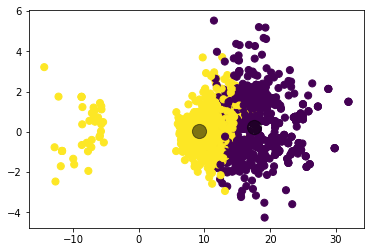

In [89]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)
Yhat = kmeans.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=Yhat,s=50, cmap='viridis') #Confirm dropping the yellow outliers 
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()  

In [92]:
print('Result of testing on training data of KMeans:')
cluster2Filler(X,y,Yhat,0)
cluster2Filler(X,y,Yhat,1)

Result of testing on training data of KMeans:
Cluster 0 is mostly Filler record ( 90.65% TP);  Filler record is also in clusters 1(9.35%) 
Cluster 1 is mostly Normal record ( 72.72% TP);  Normal record is also in clusters 0(27.28%) 


Comment: *****

### 8.1.2 Spectral Clustering

/Users/ThyDo/anaconda2/envs/py35/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:234: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Spectral Clustering result:
Cluster 0 is mostly Normal record ( 97.22% TP);  Normal record is also in clusters 1(2.78%) 
Cluster 1 is mostly Normal record ( 2.78% TP);  Normal record is also in clusters 0(97.22%) 


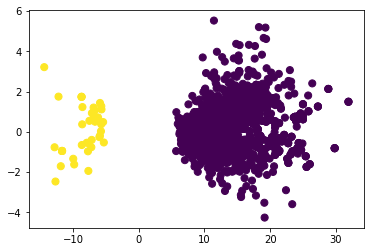

In [114]:
from sklearn.cluster import SpectralClustering
sc = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',assign_labels='kmeans')
labels = sc.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');

print('Spectral Clustering result:')
cluster2Filler(X,y,labels,0)
cluster2Filler(X,y,labels,1)

The clustering detects both cluster as 'non-filler' cluster. Both clusters contain a high number of 'non-filler' waves. Clearly, 'is-filler' waves is not fully separated. However, we're curious on what information the yellow outliers contain

In [106]:
print("Exploring the outliers")
outlier_idx = [idx for idx in range(len(labels)) if labels[idx] == 1]
#Check the outlier's information
df.iloc[outlier_idx].head()
print("Spectral Clustering's outliers has " + str(df.iloc[outlier_idx]['is Filler'].sum()) + " filler files")

Exploring the outliers
Spectral Clustering's outliers has 7 filler files


### 8.1.3 Mini Batch Kmeans

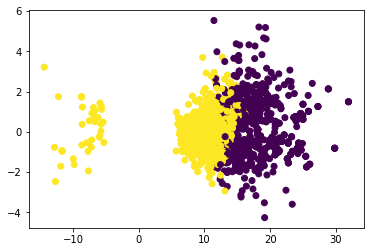

Mini batch Kmeans result:
Cluster 0 is mostly Filler record ( 90.65% TP);  Filler record is also in clusters 1(9.35%) 
Cluster 1 is mostly Normal record ( 72.28% TP);  Normal record is also in clusters 0(27.72%) 


In [112]:
from sklearn import cluster, mixture
mb= cluster.MiniBatchKMeans(2)
mb_result=mb.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],  c=mb_result)
plt.show()  

print('Mini batch Kmeans result:')
cluster2Filler(X,y,mb_result,0)
cluster2Filler(X,y,mb_result,1)

Mini batch Kmeans has a close result with that of Kmeans

### 8.1.4 Birch


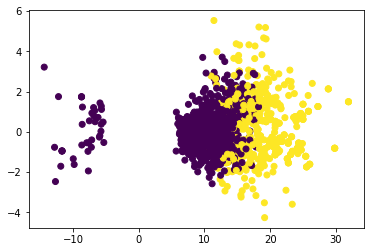

Birch Clustering result:
Cluster 0 is mostly Normal record ( 79.58% TP);  Normal record is also in clusters 1(20.42%) 
Cluster 1 is mostly Filler record ( 88.13% TP);  Filler record is also in clusters 0(11.87%) 


In [113]:
bi=cluster.Birch(n_clusters=2)
bi_result=bi.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1],  c=bi_result)
plt.show()  

print('Birch Clustering result:')
cluster2Filler(X,y,bi_result,0)
cluster2Filler(X,y,bi_result,1)

### 8.1.5 Gaussian Mixture Clustering


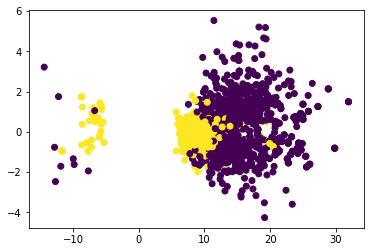

Gaussian Mixture Clustering result:
Cluster 0 is mostly Normal record ( 53.52% TP);  Normal record is also in clusters 1(46.48%) 
Cluster 1 is mostly Normal record ( 46.48% TP);  Normal record is also in clusters 0(53.52%) 


In [115]:
gm=mixture.GaussianMixture(n_components=2,covariance_type='full')
gm.fit(X)
gm_result=gm.predict(X)

plt.scatter(X[:, 0], X[:, 1],  c=gm_result)
plt.show()  

print('Gaussian Mixture Clustering result:')
cluster2Filler(X,y,gm_result,0)
cluster2Filler(X,y,gm_result,1)

Comment: Again, the GM clustering still detects both cluster as 'non-filler' cluster. However, this time, the algorithm seems to be worst since there is a nearly even split of Normal records in both clusters. This is quite surprising for GM Clustering for it known for working well with high dimensional data

## 8.2 Classification Algorithms

In [116]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,random_state=42,train_size=0.7)

### 8.2.1 Gaussian NB


In [117]:
#Training GaussianNB on 70% data 
from sklearn.naive_bayes import GaussianNB
GNBmodel = GaussianNB()
GNBmodel.fit(Xtrain, ytrain);
GNB_yhat = GNBmodel.predict(Xtest)
print('Gaussian NB testing accuracy score:',accuracy_score(ytest,GNB_yhat))
print('More reports')
GNB_report = classification_report(ytest, GNB_yhat, target_names=['Normal Record','Filler Record'])
print(GNB_report)

Gaussian NB testing accuracy score: 0.9590643274853801
More reports
               precision    recall  f1-score   support

Normal Record       0.97      0.97      0.97       328
Filler Record       0.95      0.94      0.94       185

  avg / total       0.96      0.96      0.96       513



In [119]:
scores = cross_val_score(GNBmodel, X, y, cv=5)
print("Gaussian NB model - cross validation mean score with 5 folds: ",scores.mean())

Gaussian NB model - cross validation mean score with 5 folds:  0.8898660260082248


### 8.2.2 Kernel SVM - Linear/RBF/Poly

#### Try implement Grid Search to find best kernel, C and gamma values


In [122]:
#Use Grid Search
from sklearn.grid_search import GridSearchCV

pca = PCA(n_components=10, whiten=True, random_state=42)
SVCModel_optimal = SVC(class_weight='balanced')
param_grid = {'svc__kernel':['linear','rbf','poly'],
              'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
model = make_pipeline(pca, SVCModel_optimal)

grid = GridSearchCV(model, param_grid)
grid.fit(X, y)
print('Optimal parameters for SVC algo:')
print(grid.best_params_)

Optimal parameters for SVC algo:
{'svc__kernel': 'rbf', 'svc__C': 50, 'svc__gamma': 0.005}


In [134]:
#Training Linear Kernel SVM on 70% data 
SVCModel = SVC(kernel='rbf', C=50,gamma=0.005)
SVCModel.fit(Xtrain, ytrain)
SVC_yhat = SVCModel.predict(Xtest)

print('SVM rbf kernel testing accuracy score:',accuracy_score(ytest,SVC_yhat))
print('More reports')
SVC_report = classification_report(ytest, SVC_yhat, target_names=['Normal Record','Filler Record'])
print(SVC_report)

SVM rbf kernel testing accuracy score: 0.9805068226120858
More reports
               precision    recall  f1-score   support

Normal Record       0.98      0.99      0.98       328
Filler Record       0.98      0.96      0.97       185

  avg / total       0.98      0.98      0.98       513



In [125]:
SVCModel = SVC(kernel='rbf', C=50,gamma=0.005)
scores = cross_val_score(SVCModel, X, y, cv=5)
print("RBF Kernel SVM Model - cross validation mean score with 5 folds: ",scores.mean())

RBF Kernel SVM Model - cross validation mean score with 5 folds:  0.9760009575677777


### 8.2.3 Logistic Regression

#### Try implement Grid Search to find best kernel, C and gamma values


In [136]:
#Training Logistic Regression on 70% data and testing on 30% data
LRModel = LogisticRegression(C=1)
LRModel.fit(Xtrain,ytrain)
LRModel_yhat = LRModel.predict(Xtest)
print('Logistic Regression testing accuracy score',accuracy_score(LRModel_yhat,ytest))
print('More reports')
LR_report = classification_report(ytest, LRModel_yhat, target_names=['Normal Record','Filler Record'])
print (LR_report)

Logistic Regression testing accuracy score 0.9415204678362573
More reports
               precision    recall  f1-score   support

Normal Record       0.93      0.98      0.96       328
Filler Record       0.96      0.87      0.91       185

  avg / total       0.94      0.94      0.94       513



In [138]:
LRModel = LogisticRegression()
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
grid = GridSearchCV(LRModel, param_grid)
grid.fit(X, y)
print(grid.best_params_)

{'C': 0.1}


In [141]:
LRModel = LogisticRegression(C=0.1)
scores = cross_val_score(LRModel, X, y, cv=5)
print("Logistic Regression Model - cross validation mean score with 5 folds: ",scores.mean())

Logistic Regression Model - cross validation mean score with 5 folds:  0.9232800116276086


### 8.2.4 Neural Network

In [146]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier()
clf.fit(Xtrain, ytrain) 
clf_yhat = clf.predict(Xtest)

print('Neural Network testing accuracy score',accuracy_score(clf_yhat,ytest))
print('More reports')
NN_report = classification_report(ytest, clf_yhat, target_names=['Normal Record','Filler Record'])
print (NN_report)

Neural Network testing accuracy score 0.9844054580896686
More reports
               precision    recall  f1-score   support

Normal Record       0.98      0.99      0.99       328
Filler Record       0.99      0.97      0.98       185

  avg / total       0.98      0.98      0.98       513



In [148]:
clf = MLPClassifier()
scores = cross_val_score(clf, X, y, cv=5)
print("Neural Network Model - cross validation mean score with 5 folds: ",scores.mean())

Neural Network Model - cross validation mean score with 5 folds:  0.9689730940553851


# 9. Choosing SVM Model, now input a sentence from user as "demo.wav"

In [149]:
SVCModel = SVC(kernel='rbf', C=10,gamma=0.005)
SVCModel.fit(X, y)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.005, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

### Start speaking when running the cell below, from * recording to * done recording. Adjust RECORD_SECONDS for the length of the audio

In [152]:
import pyaudio
import sys
import wave

CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
RECORD_SECONDS = 6
WAVE_OUTPUT_FILENAME = "demo.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK)

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data)

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


### You can change name to test_1 to test_7 for our pre-recorded tests

Frequency: 22050
Duration: 6.034285714285715 s


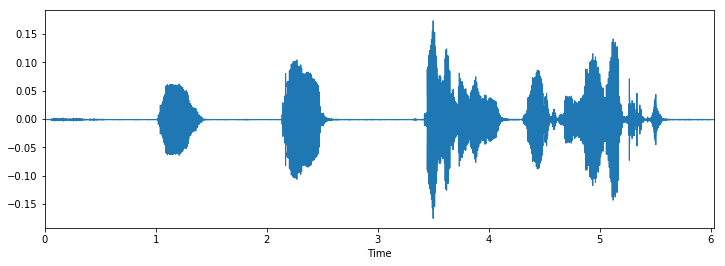

In [159]:
test_name = 'test_4'
wave, fs = librosa.load(test_name+'.wav')
print("Frequency:",fs)
print("Duration:",len(wave)/fs,"s")

plt.figure(figsize=(12, 4))
librosa.display.waveplot(wave, sr=fs)

In [158]:
ipd.Audio(wave, rate=fs)

## Predict 

In [164]:
process_audio(test_name)
test_df,test_X, test_y = csvToXY([test_name])

---Loading the test_4.wav audio file---
---Calculating RMS and Zero Crossing Rate---
---Identifying start and end time of chunks---
---Cutting the audio file into chunks---
---Deleting inaudible chunks---
Old Shape (20, 16)
New Shape (20, 4)
Component shape (4, 16)
Old Shape (20, 16)
New Shape (20, 4)
Component shape (4, 16)
Old Shape (20, 29)
New Shape (20, 4)
Component shape (4, 29)
Old Shape (20, 10)
New Shape (20, 4)
Component shape (4, 10)
Old Shape (20, 24)
New Shape (20, 4)
Component shape (4, 24)
Old Shape (20, 6)
New Shape (20, 4)
Component shape (4, 6)
---Exporting test_4.csv---
---Printing test_4.csv---
X has 6 rows and 80 columns


In [166]:
test_df.head()

,Original File,Chunk Number,Wave,is Filler
0,test_4.wav,0,"[[15.6289207, -0.386757043, -0.0240875635, 0.1...",0
1,test_4.wav,1,"[[15.2887028, 0.428636786, 0.00209320987, -0.0...",0
2,test_4.wav,2,"[[20.2887186, 1.01668342, -0.123857059, -0.008...",0
3,test_4.wav,3,"[[12.745783, 0.365441573, -0.0345737026, 0.095...",0
4,test_4.wav,4,"[[19.0226706, 0.995869597, 0.165763689, -0.045...",0


In [167]:
test_yhat = SVCModel.predict(test_X)
test_yhat

array([0, 1, 0, 0, 0, 0])

In [171]:
#Take in the result of prediction (Yhat) and give back a list that map isFil chunk wave filename 
def predToChunk(yhat):
    filler_idx = [i for i in range(len(yhat)) if yhat[i] == 1]
    filler_chunk_number = test_df.loc[filler_idx,'Chunk Number'].values
    filler_chunk_file = []
    for c in filler_chunk_number:
        filler_chunk_file.append(c)
    return filler_chunk_file
names = predToChunk(test_yhat)
print("Chunks that are predicted to be filler ", names)

Chunks that are predicted to be filler  [1]


In [174]:
def chunkToSmooth(size,fillerChunk):
    smooth = []
    for i in range(size):
        chunk = test_df.loc[i,'Chunk Number']
        if chunk not in fillerChunk:
            smooth.append(chunk)
    smooth = sorted(smooth)
    
    #for each chunk in smooth, generate points and add in a big array
    new_audio = []
    for s in smooth:
        wave, fs = librosa.load('chunk'+str(s)+'.wav')
        new_audio += wave.tolist()

    return new_audio

In [175]:
new_demo = chunkToSmooth(len(test_yhat),names)

In [176]:
ipd.Audio(new_demo, rate=fs)